In [1]:
import tensorflow_hub as hub
import json
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Sequential

In [2]:
with open('../../jiu_annotations.json', 'r') as file:
    annotations = json.load(file)

In [3]:
labels = {'standing': 0, 'takedown': 1, 'open_guard': 2, 'half_guard': 3, 'closed_guard': 4, '5050_guard': 5, 'side_control': 6, 'mount': 7, 'back': 8, 'turtle': 9}
num_labels = len(labels)
num_keypoints = 17
num_players = 2

In [10]:
from random import shuffle

data = []

try:
    for annotation in annotations:
        label = annotation['position']
        if label[-1].isdigit():
            label = label[:-1]
        
        if annotation.get('pose1'):
            keypoints = [keypoint[:2] for keypoint in annotation['pose1']]
        else:
            keypoints = [[0] * 2] * num_keypoints
            
        if annotation.get('pose2'):
            keypoints += [keypoint[:2] for keypoint in annotation['pose2']]
        else:
            keypoints += [[0] * 2] * num_keypoints
            
        keypoints = np.array(keypoints).astype(np.float32).reshape(num_keypoints * num_players * 2)        
        
        # normalizing the keypoints
        max_x = max(keypoints)
        normalized_keypoints = keypoints / max_x
        
        data.append((normalized_keypoints, labels[label]))
    
except Exception as e:
    print("Error:", e)
    
keypoints_list = []
labels_list = []

shuffle(data)

for keypoints, label in data:
    keypoints_list.append(keypoints)
    labels_list.append(label)
    
labels_list = np.array(labels_list)

file.close()


In [14]:
TRAIN_PERCENTAGE = 0.8

train_keypoints = keypoints_list[:int(len(keypoints_list) * TRAIN_PERCENTAGE)]
train_labels = labels_list[:int(len(labels_list) * TRAIN_PERCENTAGE)]

test_keypoints = keypoints_list[int(len(keypoints_list) * TRAIN_PERCENTAGE):]
test_labels = labels_list[int(len(labels_list) * TRAIN_PERCENTAGE):]

train_keypoints = np.array(train_keypoints)
train_labels = tf.keras.utils.to_categorical(train_labels)

test_keypoints = np.array(test_keypoints)
test_labels = tf.keras.utils.to_categorical(test_labels)

print("Train: ", len(train_keypoints))
print("Test: ", len(test_keypoints))

print("Label example: ", train_labels[65])
print("Keypoint example", train_keypoints[65])

Train:  96223
Test:  24056
Label example:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Keypoint example [0.9867628  0.30286086 1.         0.2940794  0.98278195 0.2801806
 0.81386447 0.21446294 0.9263485  0.24611785 0.77016145 0.26553464
 0.9013991  0.28590006 0.6746036  0.36785236 0.71597576 0.3616172
 0.9501764  0.39734024 0.7696941  0.31344372 0.8005826  0.48394465
 0.87850964 0.48280478 0.85599345 0.6926074  0.9024019  0.6931791
 0.82300085 0.8704366  0.92489713 0.911624   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [23]:
model = Sequential([
    layers.Dense(512, activation='relu', input_shape=(num_keypoints * 2 * num_players,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_labels, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               35328     
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 109898 (429.29 KB)
Trainable params: 109898 (429.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
checkpoint_path = "weights.best.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

history = model.fit(train_keypoints, train_labels,
                    epochs=100,
                    batch_size=16,
                    validation_data=(test_keypoints, test_labels),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
6004/6014 [============================>.] - ETA: 0s - loss: 1.0678 - accuracy: 0.6252
Epoch 1: val_accuracy improved from -inf to 0.73570, saving model to weights.best.hdf5
6014/6014 [==============================] - 8s 1ms/step - loss: 1.0671 - accuracy: 0.6254 - val_loss: 0.7151 - val_accuracy: 0.7357
Epoch 2/100
5979/6014 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.7647
Epoch 2: val_accuracy improved from 0.73570 to 0.78949, saving model to weights.best.hdf5
6014/6014 [==============================] - 8s 1ms/step - loss: 0.6637 - accuracy: 0.7649 - val_loss: 0.5867 - val_accuracy: 0.7895
Epoch 3/100
5988/6014 [============================>.] - ETA: 0s - loss: 0.5482 - accuracy: 0.8052
Epoch 3: val_accuracy improved from 0.78949 to 0.82478, saving model to weights.best.hdf5
6014/6014 [==============================] - 8s 1ms/step - loss: 0.5477 - accuracy: 0.8054 - val_loss: 0.4951 - val_accuracy: 0.8248
Epoch 4/100
6011/6014 [==============

In [26]:
model.evaluate(test_keypoints, test_labels)

752/752 [==============================] - 1s 868us/step - loss: 0.1122 - accuracy: 0.9707


[0.11224979162216187, 0.9706518054008484]

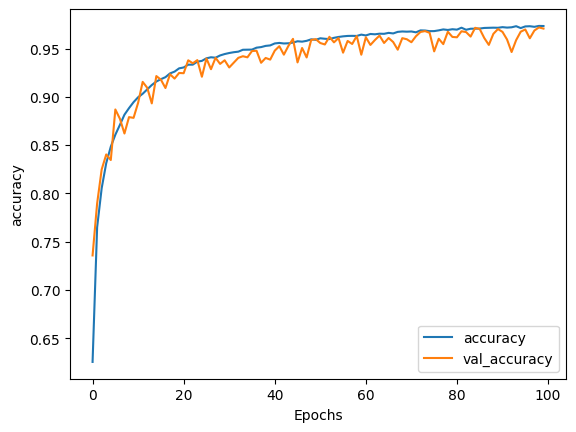

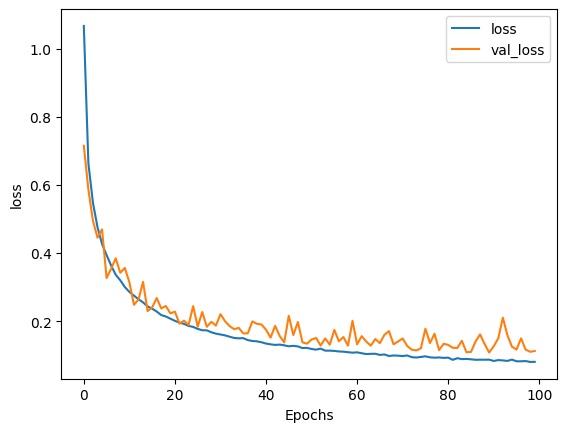

In [27]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [45]:
# REMOVE THIS LINE TO TEST THE MODEL
model_checkpoint = tf.keras.models.load_model(checkpoint_path)

model_new = tf.keras.models.load_model("jiu_model.h5")

keypoints = np.array(annotations[0]['pose2'])


keypoints = [[0] * 2] * num_keypoints
keypoints += [keypoint[:2] for keypoint in keypoints]

keypoints = np.array(keypoints).astype(np.float32).reshape(num_keypoints * num_players * 2)

print(keypoints.shape)

max_x = max(keypoints)
normalized_keypoints = keypoints / max_x

prediction = model_new.predict(normalized_keypoints.reshape(1, num_keypoints * 2 * num_players))

print(prediction)

max_index = np.argmax(prediction[0])

for label, index in labels.items():
    if index == max_index:
        print(label)
        break

(68,)
1/1 [==============================] - 0s 45ms/step
[[1.9048835e-07 5.2184078e-07 8.2079665e-04 5.0758356e-01 1.3143667e-03
  2.1391034e-03 7.1204185e-02 4.1614324e-01 3.0617858e-04 4.8790677e-04]]
half_guard


C:\Users\guilh\AppData\Local\Temp\ipykernel_23448\2140767869.py:17: RuntimeWarning: divide by zero encountered in divide
  normalized_keypoints = keypoints / max_x
C:\Users\guilh\AppData\Local\Temp\ipykernel_23448\2140767869.py:17: RuntimeWarning: invalid value encountered in divide
  normalized_keypoints = keypoints / max_x


In [29]:
# save model

model.save('jiu_model.h5')

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Calculate accuracy for each label

test_dict = {}

n = len(test_keypoints)

print(n)

for i in range(0, n):
    test = np.array([test_keypoints[i]])

    prediction = model.predict(test)
    
    correct_label = np.argmax(test_labels[i])
    predicted_label = np.argmax(prediction)
    
    label_name = list(labels.keys())[predicted_label]
    
    if predicted_label == correct_label:
        if label_name in test_dict:
            test_dict[label_name]["correct"] += 1
        else:
            test_dict[label_name] = {"correct": 1, "incorrect": 0}
    else:
        if label_name in test_dict:
            test_dict[label_name]["incorrect"] += 1
        else:
            test_dict[label_name] = {"correct": 0, "incorrect": 1}
    
for key in test_dict:
    correct = test_dict[key]["correct"]
    incorrect = test_dict[key]["incorrect"]
    
    print(f"Accuracy for {key}: {correct / (correct + incorrect)}")


24056
1/1 [==============================] - 0s 20ms/step


KeyboardInterrupt: 